<a href="https://colab.research.google.com/github/mnurakbar/TextMiningPlayground/blob/main/SentimentAnalysis_Investree.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Analisis Sentimen Review App Investree di Google Play

Mini project ini sebagai contoh aplikasi dari perkuliahan *Text Mining* dengan tujuan melakukan analisis sentimen terhadap sebuah poduk aplikasi P2P lending yaitu Investree. Investree dipilih karena dianggap memiliki *review* yang cukup beragam di Google Play.



In [1]:
!pip install google-play-scraper

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
!pip install PySastrawi

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 210.6/210.6 KB 4.6 MB/s eta 0:00:00


In [3]:
! pip install gdown

import gdown

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [4]:
from google_play_scraper import Sort, reviews_all, reviews
import re
import pandas as pd
import numpy as np
import datetime as dt
import string
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px
import plotly.graph_objects as go
from textblob import TextBlob
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, recall_score, precision_score
from sklearn.metrics import confusion_matrix, classification_report
import nltk
nltk.download('punkt')
from nltk.tokenize import word_tokenize
from nltk.probability import FreqDist
from wordcloud import WordCloud

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


In [5]:
#scraping review investree

data_investree, continuation_token = reviews('id.investree', # defaults to 0
                                        lang='id', # defaults to 'id'
                                        country='id', # defaults to 'id'
                                        sort=Sort.NEWEST, # defaults to sort.MOST_RELEVANT
                                        count=1500) 

In [6]:
investree = pd.DataFrame(data_investree)
investree.head()

,reviewId,userName,userImage,content,score,thumbsUpCount,reviewCreatedVersion,at,replyContent,repliedAt
0,c1145e53-f343-4263-9582-a429690134bb,Sri Wahyuni,https://play-lh.googleusercontent.com/a-/ACB-R...,"Maaf sy ksh bintang 2 ,sy investasi di slh sat...",2,0,2.40.0,2023-03-07 03:23:24,Mohon maaf atas ketidaknyamanan yang Anda alam...,2023-03-08 07:13:52
1,0b7e790a-6b31-4caf-a845-fdf0485e6f40,Yuga Permana,https://play-lh.googleusercontent.com/a/AGNmyx...,tolong hapus data saya....saya tidak jadi peng...,1,0,2.40.0,2023-03-06 12:24:36,Terima kasih atas penilaian Anda. Kami senanti...,2023-03-06 18:54:25
2,45bba982-6048-483b-bc40-9654bc5e5ea9,alan saputra,https://play-lh.googleusercontent.com/a-/ACB-R...,Sudah seminggu pengajuan saya belum ada kepast...,1,0,2.41.1,2023-03-05 14:30:41,Terima kasih atas penilaian Anda. Kami senanti...,2023-03-06 18:54:16
3,7f3ab496-a69e-4408-8de7-d3242b88f5e7,Ester_Gaboo Sihombing,https://play-lh.googleusercontent.com/a/AGNmyx...,"kinerja buruk, ada 2 pendanaan sudah telat bay...",1,0,2.41.1,2023-03-05 09:06:53,Mohon maaf atas ketidaknyamanan yang Anda alam...,2023-03-06 18:52:14
4,0a24a5fa-0c11-457b-9fab-0ab759ea343d,Tisna Dwija,https://play-lh.googleusercontent.com/a-/ACB-R...,Kode referall PMUZH,5,0,2.40.0,2023-02-24 18:16:32,Terima kasih atas penilaian Anda! Kami senanti...,2023-02-28 12:49:30



## Eksplorasi Dataset
Langkah untuk memahami data sebelum dilakukan praproses

In [7]:
#cek jumlah kolom

investree.columns

Index(['reviewId', 'userName', 'userImage', 'content', 'score',
       'thumbsUpCount', 'reviewCreatedVersion', 'at', 'replyContent',
       'repliedAt'],
      dtype='object')

In [8]:
#cek summary data

info = investree.info()
print('Ringkasan informasi:', info)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1052 entries, 0 to 1051
Data columns (total 10 columns):
 #   Column                Non-Null Count  Dtype         
---  ------                --------------  -----         
 0   reviewId              1052 non-null   object        
 1   userName              1052 non-null   object        
 2   userImage             1052 non-null   object        
 3   content               1052 non-null   object        
 4   score                 1052 non-null   int64         
 5   thumbsUpCount         1052 non-null   int64         
 6   reviewCreatedVersion  826 non-null    object        
 7   at                    1052 non-null   datetime64[ns]
 8   replyContent          1029 non-null   object        
 9   repliedAt             1029 non-null   datetime64[ns]
dtypes: datetime64[ns](2), int64(2), object(6)
memory usage: 82.3+ KB
Ringkasan informasi: None


##Visualisasi Data

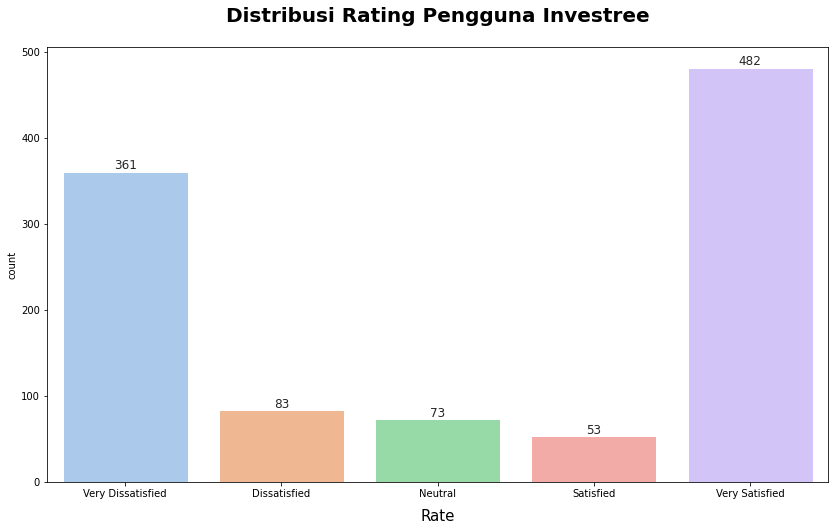

In [9]:
#visualisasi bar chart untuk melihat jumlah rating 

fig, ax = plt.subplots(figsize=(14,8))
position = (0,1,2,3,4)
labels = ("Very Dissatisfied","Dissatisfied","Neutral","Satisfied","Very Satisfied")

ax = sns.set_style('whitegrid')
ax = sns.countplot(x="score", data=investree, palette="pastel")

for rect in ax.patches:
    ax.text (rect.get_x() + rect.get_width()  / 2,
             rect.get_height()+ 3.25,rect.get_height(),
             horizontalalignment='center', fontsize = 12)

plt.title('Distribusi Rating Pengguna Investree', fontsize=20, fontweight='bold', pad=25)
plt.xlabel('Rate', fontsize=15, labelpad=10)
plt.xticks(position, labels)
# plt.ylim(1)
plt.show()

In [10]:
investree.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1052 entries, 0 to 1051
Data columns (total 10 columns):
 #   Column                Non-Null Count  Dtype         
---  ------                --------------  -----         
 0   reviewId              1052 non-null   object        
 1   userName              1052 non-null   object        
 2   userImage             1052 non-null   object        
 3   content               1052 non-null   object        
 4   score                 1052 non-null   int64         
 5   thumbsUpCount         1052 non-null   int64         
 6   reviewCreatedVersion  826 non-null    object        
 7   at                    1052 non-null   datetime64[ns]
 8   replyContent          1029 non-null   object        
 9   repliedAt             1029 non-null   datetime64[ns]
dtypes: datetime64[ns](2), int64(2), object(6)
memory usage: 82.3+ KB


##Data Cleansing
Proses menyiapkan data dengan cara menghapus atau memodifikasi data yang salah, tidak relevan, tidak akurat, duplikat, maupun yang tidak terformat

In [11]:
#Hapus semua kolom selain "content" karena dianggap kurang relevan untuk task Sentiment Analysis

investree.drop(['reviewId','userName','userImage','score','thumbsUpCount','reviewCreatedVersion','at','replyContent','repliedAt'], axis=1, inplace=True)
investree.info()
investree.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1052 entries, 0 to 1051
Data columns (total 1 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   content  1052 non-null   object
dtypes: object(1)
memory usage: 8.3+ KB


,content
0,"Maaf sy ksh bintang 2 ,sy investasi di slh sat..."
1,tolong hapus data saya....saya tidak jadi peng...
2,Sudah seminggu pengajuan saya belum ada kepast...
3,"kinerja buruk, ada 2 pendanaan sudah telat bay..."
4,Kode referall PMUZH


In [12]:
#hapus data duplikat

#investree.duplicated().sum()
investree.drop_duplicates(inplace=True)
#investree.duplicated().sum()

In [13]:
#ubah semua huruf menjadi huruf kecil

def lowercase(review_text):
  low = review_text.lower()
  return low

investree['clean_review'] = investree['content'].apply(lambda low:lowercase(str(low)))

In [14]:
#hapus emoji 

def remove_emoji(review_text):
    emoji_pattern = re.compile("["
                           u"\U0001F600-\U0001F64F"  # emoticons
                           u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                           u"\U0001F680-\U0001F6FF"  # transport & map symbols
                           u"\U00002702-\U000027B0"
                           u"\U000024C2-\U0001F251"
                           u"\U0001f926-\U0001f937"
                           u"\U00010000-\U0010ffff"
                           "]+", flags=re.UNICODE)
    return emoji_pattern.sub(r'', review_text)

investree['clean_review'] = investree['clean_review'].apply(lambda emoji: remove_emoji(emoji))

In [15]:
#hapus hashtag

def remove_hashtag(review_text, default_replace=""):
  hashtag = re.sub(r'#\w+', default_replace, review_text)
  return hashtag

investree['clean_review'] = investree['clean_review'].apply(lambda hashtag: remove_hashtag(hashtag))

In [16]:
#hapus angka

def remove_number(review_text, default_replace=" "):
  num = re.sub(r'\d+', default_replace, review_text)
  return num

investree['clean_review'] = investree['clean_review'].apply(lambda num: remove_number(num))

In [17]:
#hapus tanda baca

def remove_punctuation(review_text, default_text=" "):
  list_punct = string.punctuation
  delete_punct = str.maketrans(list_punct,' '*len(list_punct))
  new_review = ' '.join(review_text.translate(delete_punct).split())

  return new_review

investree['clean_review'] = investree['clean_review'].apply(lambda punct: remove_punctuation(punct))

In [18]:
#hapus spasi berlebih

def remove_extra_whitespaces(review_text):
  review = re.sub(r'\s+',' ', review_text)
  return review

investree['clean_review'] = investree['clean_review'].apply(lambda extra_spaces: remove_extra_whitespaces(extra_spaces))

In [19]:
#pembatasan kata berulang

def repetition(review_text):
  repeat = re.sub(r'\b(\w+)(?:\W\1\b)+', r'\1',review_text, flags=re.IGNORECASE)
  return repeat

investree['clean_review'] = investree['clean_review'].apply(lambda word: repetition(word))

In [20]:
#menghapus kata yang terdiri dari 3 huruf

def remove_small_words(text):
  text = re.sub(r'\b\w{1,3}\b','',text)
  return text

In [21]:
investree['clean_review'] = investree['clean_review'].apply(lambda remove: remove_small_words(str(remove)))

In [22]:
investree.head(10)

,content,clean_review
0,"Maaf sy ksh bintang 2 ,sy investasi di slh sat...",maaf bintang investasi satu smpai saat ...
1,tolong hapus data saya....saya tidak jadi peng...,tolong hapus data saya tidak jadi pengajuan ri...
2,Sudah seminggu pengajuan saya belum ada kepast...,sudah seminggu pengajuan saya belum kepastian...
3,"kinerja buruk, ada 2 pendanaan sudah telat bay...",kinerja buruk pendanaan sudah telat bayar har...
4,Kode referall PMUZH,kode referall pmuzh
5,Sangat tidak di rekomendasi kan buat yg mau in...,sangat tidak rekomendasi buat instal aplik...
6,busuk,busuk
7,"pinjaman sudah telat sampai 450 hari, tapi tid...",pinjaman sudah telat sampai hari tapi tidak p...
8,"Saya ingin menghapus data saya, terimakasih",saya ingin menghapus data saya terimakasih
9,Gw pikir dgn potongan biaya admin yg besar ga ...,pikir potongan biaya admin besar bakalan ...


###Normalisasi Kata
Mengubah kata menjadi bentuk standar

In [23]:
!gdown --id 1JtEcGoUPHuGbwOxTICMUguIZ62Q_fNd7

slangs = open('slang.txt',"r",encoding="utf-8", errors='replace')


/usr/local/lib/python3.9/dist-packages/gdown/cli.py:127: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Downloading...
From: https://drive.google.com/uc?id=1JtEcGoUPHuGbwOxTICMUguIZ62Q_fNd7
To: /content/slang.txt
100% 32.8k/32.8k [00:00<00:00, 31.1MB/s]


In [24]:
clear_slangs= []
for newlines in slangs:
  strip_re = newlines.strip("\n")
  split = re.split(r'[:]',strip_re)
  clear_slangs.append(split)

print(clear_slangs)

[['& ', ' dan'], ['dr ', ' dari'], ['abis ', ' habis'], ['ad ', ' ada'], ['alhmdulillah ', ' alhamdulillah'], ['alhamdulilah ', ' alhamdulillah'], ['alhamdulillaah ', ' alhamdulillah'], ['alhamdulillah ', ' alhamdulillah'], ['adminnya ', ' admin nya'], ['account ', ' akun'], ['asiikk ', ' asyik'], ['alpukatnya ', ' alpukat nya'], ['amin ', ' aamiin'], ['aplikasinnya ', ' aplikasi nya'], ['aplikasinya ', ' aplikasi nya'], ['awesome ', ' luar biasa'], ['asyilk ', ' asyik'], ['antaran ', ' pengantaran'], ['apus ', ' hapus'], ['ampe ', ' sampai'], ['almt ', ' alamat'], ['almat ', ' alamat'], ['alamt ', ' alamat'], ['almtnya ', ' alamatnya'], ['apknya ', ' aplikasinya'], ['antri ', ' antre'], ['adl ', ' adalah'], ['awalnnya ', ' awalnya'], ['asem ', ' asam'], ['alumunium ', ' aluminium'], ['abis ', ' habis'], ['areaku ', ' area saya'], ['alpulat ', ' alpukat'], ['adlah ', ' adalah'], ['applikasi ', ' aplikasi'], ['apps ', ' aplikasi'], ['app ', ' aplikasi'], ['afordable ', ' affordable'], [

In [25]:
slangs = [[k.strip(), v.strip()] for k,v in clear_slangs]
dict_slangs = {key:values for key,values in slangs}
#dict_slangs

In [26]:
clean_text = []
for review in investree['clean_review']:
  wordlist = TextBlob(review).words
  for k,v in enumerate(wordlist):
    if v in dict_slangs.keys():
      wordlist[k] = dict_slangs[v]
  clean_text.append(' '.join(wordlist))

In [27]:
#clean_text

In [28]:
investree['normalization'] = clean_text
investree.head(20)

,content,clean_review,normalization
0,"Maaf sy ksh bintang 2 ,sy investasi di slh sat...",maaf bintang investasi satu smpai saat ...,maaf bintang investasi satu sampai saat baliki...
1,tolong hapus data saya....saya tidak jadi peng...,tolong hapus data saya tidak jadi pengajuan ri...,tolong hapus data saya tidak jadi pengajuan ru...
2,Sudah seminggu pengajuan saya belum ada kepast...,sudah seminggu pengajuan saya belum kepastian...,sudah seminggu pengajuan saya belum kepastian ...
3,"kinerja buruk, ada 2 pendanaan sudah telat bay...",kinerja buruk pendanaan sudah telat bayar har...,kinerja buruk pendanaan sudah terlambat bayar ...
4,Kode referall PMUZH,kode referall pmuzh,kode referall pmuzh
5,Sangat tidak di rekomendasi kan buat yg mau in...,sangat tidak rekomendasi buat instal aplik...,sangat tidak rekomendasi buat memasang aplikas...
6,busuk,busuk,busuk
7,"pinjaman sudah telat sampai 450 hari, tapi tid...",pinjaman sudah telat sampai hari tapi tidak p...,pinjaman sudah terlambat sampai hari tapi tida...
8,"Saya ingin menghapus data saya, terimakasih",saya ingin menghapus data saya terimakasih,saya ingin menghapus data saya terima kasih
9,Gw pikir dgn potongan biaya admin yg besar ga ...,pikir potongan biaya admin besar bakalan ...,pikir potongan biaya admin besar bakalan masal...


##*Text Preprocessing*
Mengubah teks dari bahasa manusia (tidak terstruktur) ke format yang dapat dibaca mesin (terstruktur) untuk diproses ke tahap yang lebih lanjut

###Tokenizing
Membagi teks yang dapat berupa kalimat, paragraf atau dokumen, menjadi token-token/bagian-bagian tertentu

In [29]:
def word_token(review_text):
  return word_tokenize(review_text)

In [30]:
investree['tokenizing'] = investree['normalization'].apply(lambda tokenize:word_token(str(tokenize)))
# investree.head()


###Stopword Removal
Menghapus kata yang tidak relevan didalam suatu kalimat berdasarkan daftar stopword

In [31]:
from nltk.corpus import stopwords
nltk.download('stopwords')
nltk.download('popular')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading collection 'popular'
[nltk_data]    | 
[nltk_data]    | Downloading package cmudict to /root/nltk_data...
[nltk_data]    |   Unzipping corpora/cmudict.zip.
[nltk_data]    | Downloading package gazetteers to /root/nltk_data...
[nltk_data]    |   Unzipping corpora/gazetteers.zip.
[nltk_data]    | Downloading package genesis to /root/nltk_data...
[nltk_data]    |   Unzipping corpora/genesis.zip.
[nltk_data]    | Downloading package gutenberg to /root/nltk_data...
[nltk_data]    |   Unzipping corpora/gutenberg.zip.
[nltk_data]    | Downloading package inaugural to /root/nltk_data...
[nltk_data]    |   Unzipping corpora/inaugural.zip.
[nltk_data]    | Downloading package movie_reviews to
[nltk_data]    |     /root/nltk_data...
[nltk_data]    |   Unzipping corpora/movie_reviews.zip.
[nltk_data]    | Downloading package names to /root/nltk_data...
[nltk_data] 

True

In [32]:
#kata stopwords bahasa indonesia

indonesian_stop = stopwords.words('indonesian')

In [33]:
#masukkan stopwords bahasa indonesia ke dalam dataframe

stopwords_indo = pd.DataFrame(indonesian_stop, columns=['stopwords_indonenesia'])

In [34]:
#fungsi menghapus stopword pada dataset

def remove_stopwords(review_text, indo_stopwords):
  tokenize = []
  for token in review_text:
    if token not in indo_stopwords:
      tokenize.append(token)
  
  return tokenize

investree['stopword_removed'] = investree['tokenizing'].apply(lambda stop: remove_stopwords(stop, indonesian_stop))

###Stemming
Proses mengubah kata menjadi bentuk dasar dengan cara menghapus imbuhan pada kata tersebut

In [35]:
from Sastrawi.Stemmer.StemmerFactory import StemmerFactory

In [36]:
#fungsi menerapkan stemming pada dataset

def back_to_root(review_text):
  stop_token = ' '.join(review_text)
  stem = StemmerFactory()
  create_stem = stem.create_stemmer()
  result_stem = create_stem.stem(stop_token)
  return result_stem

investree['stemming'] = investree['stopword_removed'].apply(lambda stem:back_to_root(stem))

In [37]:
investree.head()

,content,clean_review,normalization,tokenizing,stopword_removed,stemming
0,"Maaf sy ksh bintang 2 ,sy investasi di slh sat...",maaf bintang investasi satu smpai saat ...,maaf bintang investasi satu sampai saat baliki...,"[maaf, bintang, investasi, satu, sampai, saat,...","[maaf, bintang, investasi, balikin, perjanjian...",maaf bintang investasi balikin janji investree...
1,tolong hapus data saya....saya tidak jadi peng...,tolong hapus data saya tidak jadi pengajuan ri...,tolong hapus data saya tidak jadi pengajuan ru...,"[tolong, hapus, data, saya, tidak, jadi, penga...","[tolong, hapus, data, pengajuan, rumit, pember...",tolong hapus data aju rumit kes mohon maaf hap...
2,Sudah seminggu pengajuan saya belum ada kepast...,sudah seminggu pengajuan saya belum kepastian...,sudah seminggu pengajuan saya belum kepastian ...,"[sudah, seminggu, pengajuan, saya, belum, kepa...","[seminggu, pengajuan, kepastian, suruh, tanda,...",minggu aju pasti suruh tanda tangan digital cu...
3,"kinerja buruk, ada 2 pendanaan sudah telat bay...",kinerja buruk pendanaan sudah telat bayar har...,kinerja buruk pendanaan sudah terlambat bayar ...,"[kinerja, buruk, pendanaan, sudah, terlambat, ...","[kinerja, buruk, pendanaan, terlambat, bayar, ...",kerja buruk dana lambat bayar asuransi cair in...
4,Kode referall PMUZH,kode referall pmuzh,kode referall pmuzh,"[kode, referall, pmuzh]","[kode, referall, pmuzh]",kode referall pmuzh


##Data Labeling
Dalam memprediksi label sebuah text umumnya digunakan pendekatan *supervised learning*. Sebuah algoritma seperti SVM, Naive Bayes, maupun menggunakan *deep learning* akan melalui fase *training* terlebih dahulu untuk membuat sebuah model prediksi, namun pendekatan ini membutuhkan sebuah data yang sudah dilabeli sebelumnya. Dalam kasus ini idealnya data hasil review yang telah discrap dilabeli secara manual oleh seorang ahli bahasa, namun hal itu belum memungkinkan dan membutuhkan waktu yang lama. Sehingga pendekatan yang digunakan adalah lexicon-based method yaitu dengan menggunakan  InSet Lexicon, kamus kata yang berisi bobot nilai + dan -. Lebih lengkap bisa dilihat pada https://github.com/fajri91/InSet 

In [38]:
#import lexicon +

!gdown --id 1KI85cdWMh0LufxZNy5zJYqDjuiCRuYiP

/usr/local/lib/python3.9/dist-packages/gdown/cli.py:127: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Downloading...
From: https://drive.google.com/uc?id=1KI85cdWMh0LufxZNy5zJYqDjuiCRuYiP
To: /content/lexicon_positive_ver1.csv
100% 41.4k/41.4k [00:00<00:00, 4.94MB/s]


In [39]:
#import lexicon -

!gdown --id 1peTD6BO3kyNV5sW45Sa76waCv0_QNnqG

/usr/local/lib/python3.9/dist-packages/gdown/cli.py:127: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Downloading...
From: https://drive.google.com/uc?id=1peTD6BO3kyNV5sW45Sa76waCv0_QNnqG
To: /content/lexicon_negative_ver1.csv
100% 82.8k/82.8k [00:00<00:00, 45.9MB/s]


In [40]:
#baca kamus lexicon + dan -

lexicon_positive = dict()
import csv
with open('lexicon_positive_ver1.csv', 'r') as csvfile:
  reader = csv.reader(csvfile, delimiter=',')
  for row in reader:
    lexicon_positive[row[0]] = int(row[1])

lexicon_negative = dict()
import csv
with open('lexicon_negative_ver1.csv', 'r') as csvfile:
  reader = csv.reader(csvfile, delimiter=',')
  for row in reader:
    lexicon_negative[row[0]] = int(row[1])

In [41]:
#buat fungsi untuk pembobotan dataset menggunakan lexicon

def sentiment_analysis_lexicon_indonesia(text):
  score = 0
  for word_pos in text:
    if (word_pos in lexicon_positive):
      score = score + lexicon_positive[word_pos]
  for word_neg in text:
    if (word_neg in lexicon_negative):
      score = score + lexicon_negative[word_neg]
  polarity=''
  if (score > 0):
    polarity = 'positif'
  elif (score < 0):
    polarity = 'negatif'
  else:
    polarity = 'netral'
  
  return score, polarity

In [42]:
#tes fungsi lexicon yang telah dibuat

kalimat_positif = "aplikasi buruk, penipuan"
kalimat_positif = kalimat_positif.split()
hasil = sentiment_analysis_lexicon_indonesia(kalimat_positif)
hasil

(-4, 'negatif')

In [43]:
kalimat_negatif = "tersedia gratis, sangat membantu"
kalimat_negatif = kalimat_negatif.split()
hasil = sentiment_analysis_lexicon_indonesia(kalimat_negatif)
hasil


(2, 'positif')

In [44]:
#split dataset
investree['prepos_text'] = investree.stemming.str.split()

In [45]:
#aplikasikan fungsi lexicon ke dataset

results = investree['prepos_text'].apply(sentiment_analysis_lexicon_indonesia)
results = list(zip(*results))
investree['polarity_score'] = results[0]
investree['polarity'] = results[1]
print(investree['polarity'].value_counts())

negatif    535
positif    333
netral     145
Name: polarity, dtype: int64


In [46]:
hasil_polarity = investree[["content","stemming","polarity_score","polarity"]]
hasil_polarity.head()

,content,stemming,polarity_score,polarity
0,"Maaf sy ksh bintang 2 ,sy investasi di slh sat...",maaf bintang investasi balikin janji investree...,2,positif
1,tolong hapus data saya....saya tidak jadi peng...,tolong hapus data aju rumit kes mohon maaf hap...,-14,negatif
2,Sudah seminggu pengajuan saya belum ada kepast...,minggu aju pasti suruh tanda tangan digital cu...,-12,negatif
3,"kinerja buruk, ada 2 pendanaan sudah telat bay...",kerja buruk dana lambat bayar asuransi cair in...,0,netral
4,Kode referall PMUZH,kode referall pmuzh,-3,negatif


In [47]:
#hapus data netral karena fokus project ini hanya pada review + dan -
hasil_polarity = hasil_polarity.drop(hasil_polarity[hasil_polarity['polarity'] == 'netral'].index)
hasil_polarity = hasil_polarity.reset_index(drop=True)

hasil_polarity.head()

,content,stemming,polarity_score,polarity
0,"Maaf sy ksh bintang 2 ,sy investasi di slh sat...",maaf bintang investasi balikin janji investree...,2,positif
1,tolong hapus data saya....saya tidak jadi peng...,tolong hapus data aju rumit kes mohon maaf hap...,-14,negatif
2,Sudah seminggu pengajuan saya belum ada kepast...,minggu aju pasti suruh tanda tangan digital cu...,-12,negatif
3,Kode referall PMUZH,kode referall pmuzh,-3,negatif
4,Sangat tidak di rekomendasi kan buat yg mau in...,rekomendasi pasang aplikasi lambat parah bayar,-6,negatif


##Visualisasikan Hasil Polarity Sentimen

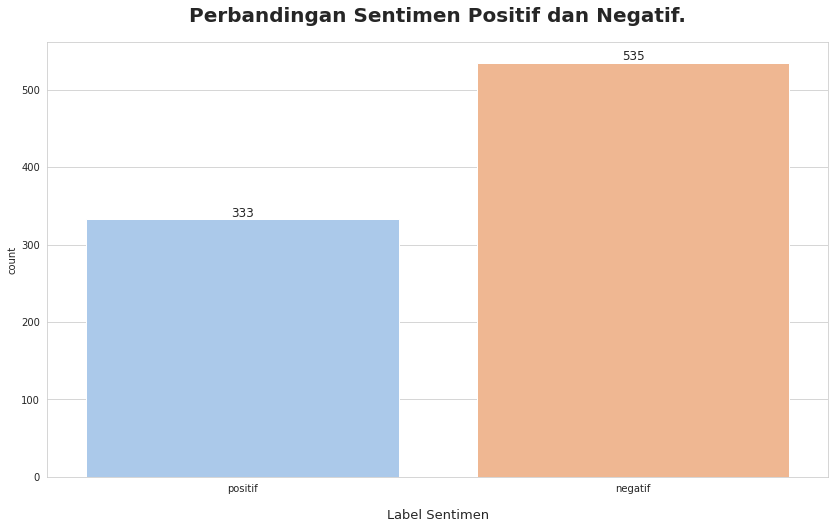

In [48]:
fig, ax = plt.subplots(figsize=(14,8))
ax = sns.countplot(x='polarity', data=hasil_polarity, palette="pastel")

for rect in ax.patches:
    ax.text (rect.get_x() + rect.get_width()  / 2,rect.get_height()+ 3.25,rect.get_height(),horizontalalignment='center', fontsize = 12)

plt.title("Perbandingan Sentimen Positif dan Negatif.", fontsize=20, fontweight='bold',pad=20)
plt.xlabel("Label Sentimen", fontsize=13, labelpad=15)
plt.ylim(0)
plt.show()

###Wordcloud Sentimen Positif

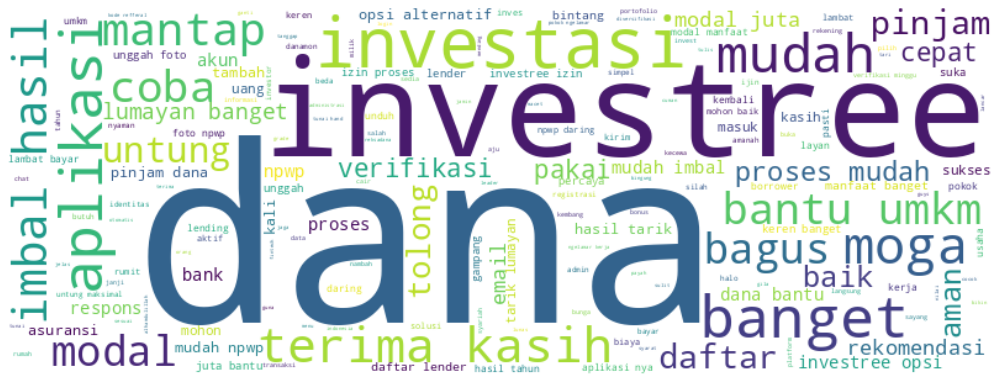

In [49]:
sentiment_pos = ' '.join([review for review in hasil_polarity['stemming'][hasil_polarity['polarity'] == "positif"]])

# create object wordcloud
w_pos = WordCloud(background_color="white",
                  width=800, height=300, max_font_size=200,
                  max_words=500).generate(sentiment_pos)

plt.figure(figsize=(14,8))
plt.axis("off")
plt.tight_layout()
plt.imshow(w_pos, interpolation="bilinear")
plt.show()

###Wordcloud Sentien Negatif

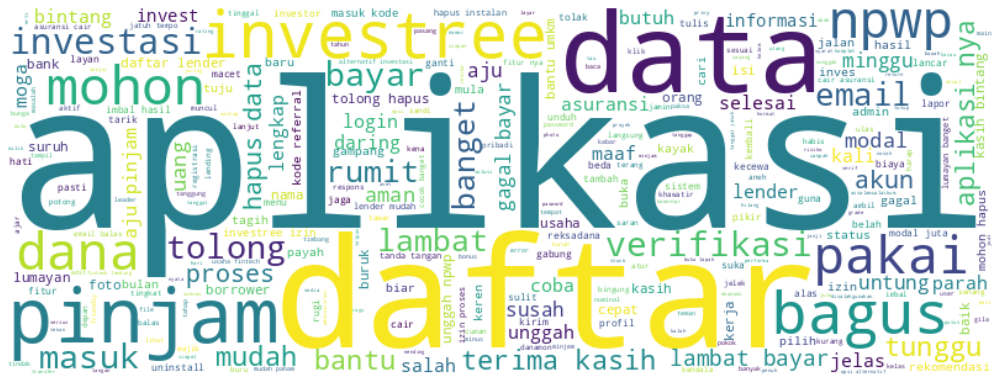

In [50]:
sentiment_neg = ' '.join([review for review in hasil_polarity['stemming'][hasil_polarity['polarity'] == "negatif"]])

# create object wordcloud
w_neg = WordCloud(background_color="white",
                  width=800, height=300, max_font_size=200,
                  max_words=500).generate(sentiment_neg)

plt.figure(figsize=(14,8))
plt.axis("off")
plt.tight_layout()
plt.imshow(w_neg, interpolation="bilinear")
plt.show()